In [1]:
import numpy as np
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from tqdm import tqdm

We notice that the key differences between the ODE model in equation (21) and the ODE models in the paper 'Kernel Ordinary Differential Equations' are whether inputs exist and whether there is a linear relationship between the state and its derivative. Since the examples in the paper do not suit the setting in equation (21) and Algorithm 3, we generate input data randomly and construct the dynamic system according to equation (21).

In [2]:
def g0(Z_t, C):
    return np.cos(Z_t @ C)# 假设是这个函数

def make_odefunc(beta_0, Z_interp, C):
    def odefunc(t, X_flat):
        X = X_flat.reshape(1, -1)
        Z_t = Z_interp(t).reshape(1, -1)
        return (X @ beta_0 + g0(Z_t, C)).flatten()
    return odefunc

In [3]:
# Stimulation data satisfying equation (21)
T = 100
p = 3
nu = 5
t_grid = np.linspace(0, 1, T) #t_grid

In [4]:
np.random.seed(11)
Z = np.random.randn(T, nu) #随机生成的数。比如T=100，nu=5，就是我收集了100个5个维度的向量

Z_interp = interp1d(t_grid, Z, axis=0, kind='cubic', fill_value="extrapolate")  # Interpolate Z(t) for continuous time within the solver
#我的ODE模拟是离散建模，只有100个点，因此需要先把数据拟合成连续的函数，在其中axis=0意思是按照时间维度建模，recalling z是txp的向量


beta_0 = np.random.randn(p, p) #beta——0 是一个pxp维度向量
X0 = np.zeros(p)

C = np.random.randn(nu, p) #映射到txp维

odefunc = make_odefunc(beta_0, Z_interp, C)
sol = solve_ivp(odefunc, [0, 1], X0, t_eval=t_grid, method='RK45')#通过这个函数得到了X(t)的true value
X_true = sol.y.T  # (T,p)

dXdt = np.zeros_like(X_true)
for idx, t in enumerate(t_grid):
    X_t = X_true[idx, :].reshape(1, -1)
    Z_t = Z[idx, :].reshape(1, -1)
    dXdt[idx, :] = (X_t @ beta_0 + g0(Z_t, C)).flatten()

In [5]:
sol.y.shape #这三个维度在1-100之间的变化

(3, 100)

In [6]:
sol.success # 求解成功

True

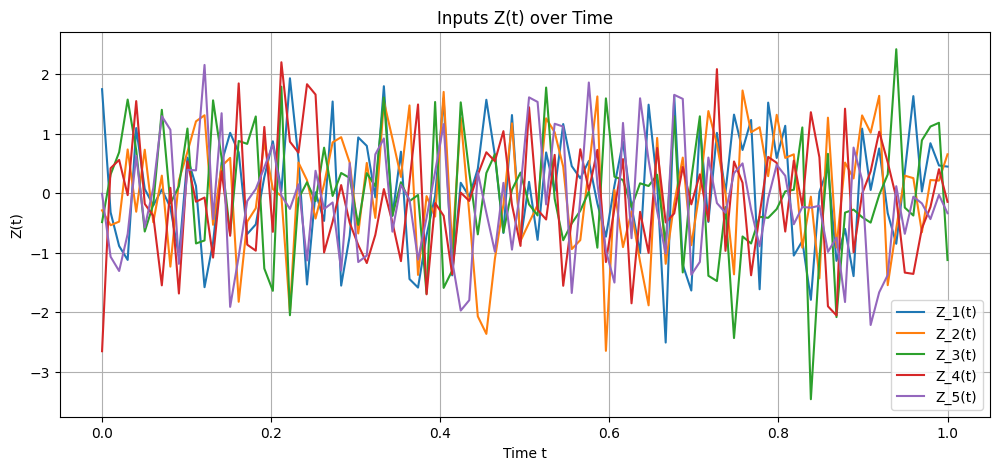

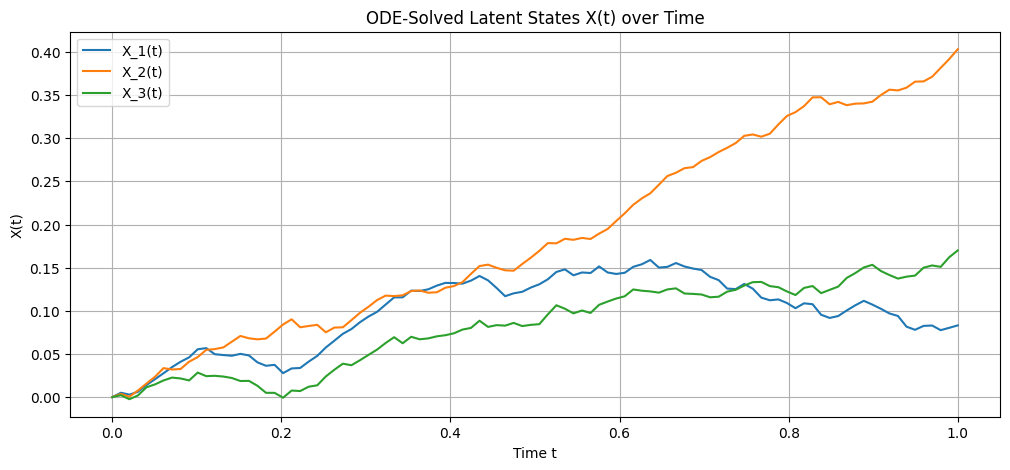

In [7]:
#可视化模拟数据
plt.figure(figsize=(12, 5))
for i in range(nu):
    plt.plot(t_grid, Z[:, i], label=f'Z_{i+1}(t)')
plt.title('Inputs Z(t) over Time')
plt.xlabel('Time t')
plt.ylabel('Z(t)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
for j in range(p):
    plt.plot(t_grid, X_true[:, j], label=f'X_{j+1}(t)')
plt.title('ODE-Solved Latent States X(t) over Time')
plt.xlabel('Time t')
plt.ylabel('X(t)')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
U = 0.05 * np.random.randn(T, p)  # noise
Y = X_true + U  # observation

Then we implement Algorithm 3. We estimate $\hat{r_q}$ by using Kernel Ridge Regression, which is based on Reproducing Kernel Hilbert Space (RKHS), and estimate $\hat{g_q}$ by using the Random Forest algorithm (since our data is simple, there's no need to use deep learning).

For solving equation (22), we first notice there is a typo in equation (22) and it should be:
$$
\psi(\boldsymbol{X}, \boldsymbol{Y}, \boldsymbol{Z}, t ; \boldsymbol{\beta}, r, \boldsymbol{g}) \equiv[r(\boldsymbol{Z}(t))-\boldsymbol{X}(t)]^{\top}\left[\boldsymbol{Y}-\int \boldsymbol{\beta}^{\top} \boldsymbol{X}(t) d t-\int g_0(\boldsymbol{Z}(t)) d t\right]
$$
to match the dimension.

Then we estimate the integral by summing over the discrete time:
$$
\int \boldsymbol{\beta}^{\top} \boldsymbol{X}(t) d t = \sum_{k=1}^{\ell} \Delta t \cdot \boldsymbol{\beta}^{\top} \boldsymbol{X}\left(t_k\right)
$$
$$
\int \boldsymbol{g}_0(\boldsymbol{Z}(t)) d t = \sum_{k=1}^{\ell} \Delta t \cdot \boldsymbol{g}_0\left(\boldsymbol{Z}\left(t_k\right)\right)
$$
and plug in our estimator $\hat{r_q}, \hat{g_q}$ for $r, g_0$:
$$
\widehat{\psi}_{\ell}=\left[\hat{r_q}\left(\boldsymbol{Z}\left(t_{\ell}\right)\right)-\boldsymbol{X}\left(t_{\ell}\right)\right]^{\top}\left[\boldsymbol{Y}\left(t_{\ell}\right)-\sum_{k=1}^{\ell} \Delta t \cdot \boldsymbol{\beta}^{\top} \boldsymbol{X}\left(t_k\right)-\sum_{k=1}^{\ell} \Delta t \cdot \hat{g_q}\left(\boldsymbol{Z}\left(t_k\right)\right)\right].
$$

To find $\beta$, we need the sum of these scores over all $t_{\ell}$ to be 0(?): $\sum_{\ell=1}^T \widehat{\psi}_{\ell}=0$, which is equivalent to:
$$
\sum_{\ell=1}^T\left[\hat{r_q}\left(\boldsymbol{Z}\left(t_{\ell}\right)\right)-\boldsymbol{X}\left(t_{\ell}\right)\right]^{\top}\boldsymbol{\beta}^{\top} \left[\sum_{k=1}^{\ell} \Delta t \cdot \boldsymbol{X}\left(t_k\right)\right] =\sum_{\ell=1}^T\left[\hat{r_q}\left(\boldsymbol{Z}\left(t_{\ell}\right)\right)-\boldsymbol{X}\left(t_{\ell}\right)\right]^{\top}\left[\boldsymbol{Y}\left(t_{\ell}\right)-\sum_{k=1}^{\ell} \Delta t \cdot \hat{g_q}\left(\boldsymbol{Z}\left(t_k\right)\right)\right]
$$


Let
- $V_{\ell}=-\left[\hat{r_q}\left(\boldsymbol{Z}\left(t_{\ell}\right)\right)-\boldsymbol{X}\left(t_{\ell}\right)\right] \in \mathbb{R}^p$, we can generate it as multivariate normal noise.
- $S_{\ell}=\sum_{k=1}^{\ell} \Delta t \cdot \boldsymbol{X}\left(t_k\right) \in \mathbb{R}^p$
- $G_{\ell}=\left[\boldsymbol{Y}\left(t_{\ell}\right)-\sum_{k=1}^{\ell} \Delta t \cdot \hat{g_q}\left(\boldsymbol{Z}\left(t_k\right)\right)\right] \in \mathbb{R}^p$.

Our goal is to solve:
$$
\sum_{\ell=1}^T V_{\ell}^{\top} \boldsymbol{\beta}^{\top} S_{\ell}=\sum_{\ell=1}^T V_{\ell}^{\top}G_{\ell}
$$

In [9]:
Q = 5
kf = KFold(n_splits=Q, shuffle=True, random_state=1)
theta_q_list = []

for Iqc, Iq in kf.split(range(T)):
    # Estimate r_hat, g_hat on Iqc (complement of chunk q)
    Z_qc, Y_qc = Z[Iqc], Y[Iqc]
    Z_q, Y_q = Z[Iq], Y[Iq]
    dXdt_q = dXdt[Iq]

    r_hat = KernelRidge(kernel='rbf', alpha=1.0)  # Estimate r_hat with kernel ridge regression
    r_hat.fit(Z_qc, Y_qc)
    r_hat_q = r_hat.predict(Z_q)
    g_hat = RandomForestRegressor(n_estimators=100)  # Estimate g_hat with Random Forest
    g_hat.fit(Z_qc, dXdt[Iqc])
    g_hat_q = g_hat.predict(Z_q)

    # Solve for beta_hat using Neyman orthogonal score


Here we consider $p=1, \nu=2$, then our simulate data are:

In [10]:
# Stimulation data satisfying equation (21
T = 10000
p = 1
nu = 2
t_grid = np.linspace(0, 1, T)
np.random.seed(11)
Z = np.random.randn(T, nu)
Z_interp = interp1d(t_grid, Z, axis=0, kind='cubic', fill_value="extrapolate")  # Interpolate Z(t) for continuous time within the solver

beta_0 = 10 * np.random.randn(p, p)
X0 = np.zeros(p)

C = np.random.randn(nu, p)

odefunc = make_odefunc(beta_0, Z_interp, C)
sol = solve_ivp(odefunc, [0, 1], X0, t_eval=t_grid, method='RK45')
X_true = sol.y.T  # (T,p)

dXdt = np.zeros_like(X_true)
for idx, t in enumerate(t_grid):
    X_t = X_true[idx, :].reshape(1, -1)
    Z_t = Z[idx, :].reshape(1, -1)
    dXdt[idx, :] = (X_t @ beta_0 + g0(Z_t, C)).flatten()

In [11]:
g0(Z_t, C)

array([[0.16250696]])

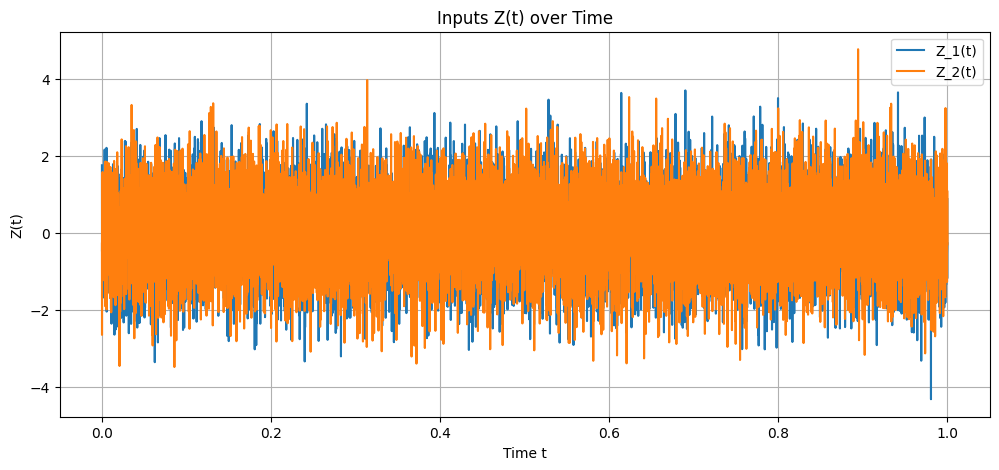

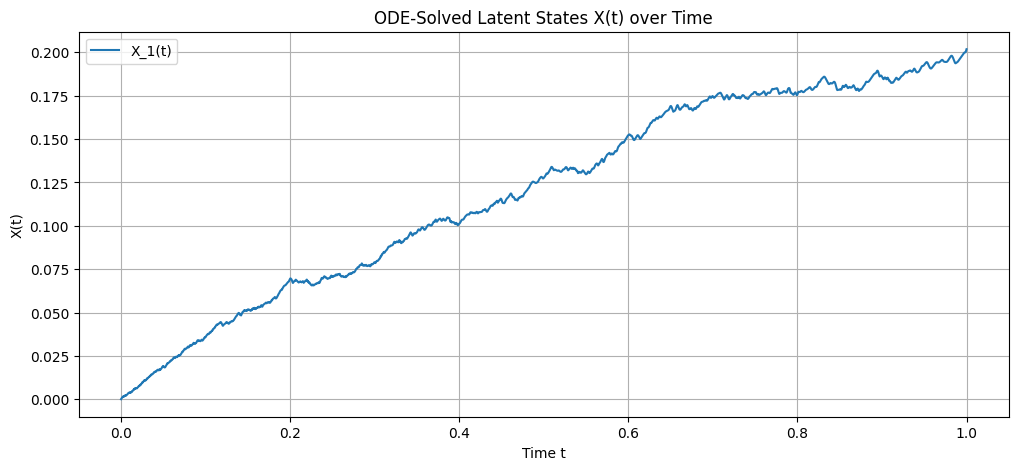

In [12]:
plt.figure(figsize=(12, 5))
for i in range(nu):
    plt.plot(t_grid, Z[:, i], label=f'Z_{i+1}(t)')
plt.title('Inputs Z(t) over Time')
plt.xlabel('Time t')
plt.ylabel('Z(t)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
for j in range(p):
    plt.plot(t_grid, X_true[:, j], label=f'X_{j+1}(t)')
plt.title('ODE-Solved Latent States X(t) over Time')
plt.xlabel('Time t')
plt.ylabel('X(t)')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
U = 0.05 * np.random.randn(T, p)  # noise
Y = X_true + U  # observation

$$
\sum_{\ell=1}^T\left[\hat{r_q}\left(\boldsymbol{Z}\left(t_{\ell}\right)\right)-\boldsymbol{X}\left(t_{\ell}\right)\right]\boldsymbol{\beta} \left[\sum_{k=1}^{\ell} \Delta t \cdot \boldsymbol{X}\left(t_k\right)\right] =\sum_{\ell=1}^T\left[\hat{r_q}\left(\boldsymbol{Z}\left(t_{\ell}\right)\right)-\boldsymbol{X}\left(t_{\ell}\right)\right]\left[\boldsymbol{Y}\left(t_{\ell}\right)-\sum_{k=1}^{\ell} \Delta t \cdot \hat{g_q}\left(\boldsymbol{Z}\left(t_k\right)\right)\right]
$$
Since we can't observe $X(t)$, we need to plug in $Y(t)$ as an unbiased estimator, and we use $\hat{r_q}\left(\boldsymbol{Z}\left(t_{\ell}\right)\right)$ to estimate $Y(t)$. Let $$
\begin{aligned}
& d_{\ell}=\hat{r_q}\left(\boldsymbol{Z}\left(t_{\ell}\right)\right)-\boldsymbol{Y}\left(t_{\ell}\right)\\
& s_{\ell}=\sum_{k=1}^{\ell} \Delta t \cdot \boldsymbol{Y}\left(t_k\right) \\
& g_{\ell}=\sum_{k=1}^{\ell} \Delta t \cdot \hat{g_q}\left(\boldsymbol{Z}\left(t_k\right)\right)
\end{aligned}
$$
then
$$
\widehat{\beta}=\frac{\sum_{\ell=1}^T d_{\ell} \cdot\left[\hat{r_q}\left(\boldsymbol{Z}\left(t_{\ell}\right)\right)-g_{\ell}\right]}{\sum_{\ell=1}^T d_{\ell} \cdot s_{\ell}}
$$

🌟Y(t)是X(t)的无偏估计//

🌟值得注意的是这里的Y(tl) 我们用了$$\hat{r_q}(Z(t_l))$$

作为替代的效果更好❓

In [20]:
Q = 20
kf = KFold(n_splits=Q, shuffle=True, random_state=1)
beta_q_list = []
Delta_t = t_grid[1] - t_grid[0]

for Iqc, Iq in tqdm(kf.split(range(T)), total=Q, desc="Cross-fitting"):
    # Estimate r_hat, g_hat on Iqc (complement of chunk q)
    Z_qc, Y_qc = Z[Iqc], Y[Iqc]
    Z_q, Y_q = Z[Iq], Y[Iq]
    dXdt_q = dXdt[Iq]

    r_hat = KernelRidge(kernel='rbf', alpha=1.0)  # Estimate r_hat with kernel ridge regression
    r_hat.fit(Z_qc, Y_qc)
    r_hat_q = r_hat.predict(Z_q)
    g_hat = RandomForestRegressor(n_estimators=100)  # Estimate g_hat with Random Forest
    g_hat.fit(Z_qc, dXdt[Iqc].ravel())
    g_hat_q = g_hat.predict(Z_q)

    # Solve for beta_hat using Neyman orthogonal score
    d_l = r_hat_q.flatten() - Y_q.flatten()  # shape (len(Iq),)
    s_l = np.cumsum(Y_q.flatten()) * Delta_t  # integrate X using observed Y
    g_l = np.cumsum(g_hat_q) * Delta_t  # integrate g_hat

    beta_hat_q = np.sum(d_l * (r_hat_q.flatten() - g_l)) / np.sum(d_l * s_l)#这里用r_hat_q估计效果更好，why
    beta_q_list.append(beta_hat_q)

# Average over Q chunks
beta_hat = np.mean(beta_q_list)

Cross-fitting: 100%|██████████| 20/20 [03:09<00:00,  9.47s/it]


In [15]:
print("Estimated beta:\n", beta_hat)
print("True beta:\n", beta_0)

Estimated beta:
 -1.6318654767415537
True beta:
 [[-1.36141304]]


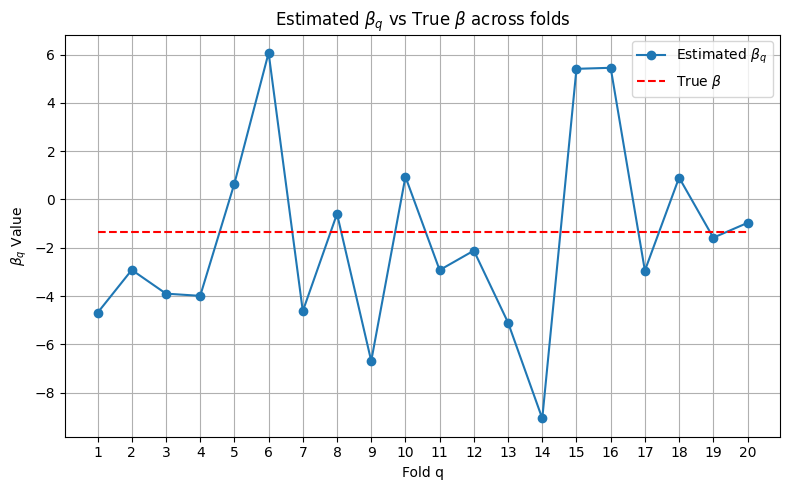

In [21]:
# Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(beta_q_list) + 1), beta_q_list, marker='o', label='Estimated $\\beta_q$')
plt.hlines(beta_0, 1, len(beta_q_list), colors='red', linestyles='dashed', label='True $\\beta$')
plt.xlabel('Fold q')
plt.ylabel('$\\beta_q$ Value')
plt.title('Estimated $\\beta_q$ vs True $\\beta$ across folds')
plt.xticks(range(1, len(beta_q_list) + 1))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 如果就按照于原来的式子测试

In [16]:
Q = 20
kf = KFold(n_splits=Q, shuffle=True, random_state=1)
beta_q_list = []
Delta_t = t_grid[1] - t_grid[0]

for Iqc, Iq in tqdm(kf.split(range(T)), total=Q, desc="Cross-fitting"):
    # Estimate r_hat, g_hat on Iqc (complement of chunk q)
    Z_qc, Y_qc = Z[Iqc], Y[Iqc]
    Z_q, Y_q = Z[Iq], Y[Iq]
    dXdt_q = dXdt[Iq]

    r_hat = KernelRidge(kernel='rbf', alpha=1.0)  # Estimate r_hat with kernel ridge regression
    r_hat.fit(Z_qc, Y_qc)
    r_hat_q = r_hat.predict(Z_q)
    g_hat = RandomForestRegressor(n_estimators=100)  # Estimate g_hat with Random Forest
    g_hat.fit(Z_qc, dXdt[Iqc].ravel())
    g_hat_q = g_hat.predict(Z_q)

    # Solve for beta_hat using Neyman orthogonal score
    d_l = r_hat_q.flatten() - Y_q.flatten()  # shape (len(Iq),)
    s_l = np.cumsum(Y_q.flatten()) * Delta_t  # integrate X using observed Y
    g_l = np.cumsum(g_hat_q) * Delta_t  # integrate g_hat

    beta_hat_q = np.sum(d_l * (Y_q.flatten() - g_l)) / np.sum(d_l * s_l)#这里用r_hat_q估计效果更好，why
    beta_q_list.append(beta_hat_q)

# Average over Q chunks
beta_hat = np.mean(beta_q_list)

Cross-fitting: 100%|██████████| 20/20 [03:08<00:00,  9.42s/it]


In [18]:
print("Estimated beta:\n", beta_hat)
print("True beta:\n", beta_0)

Estimated beta:
 57.21948070985955
True beta:
 [[-1.36141304]]


$$\hat{r_q}(Z(t_l))$$
也是无偏估计,但是效果比Y(t)好很多。
这里如果用Y（tl）效果却很差


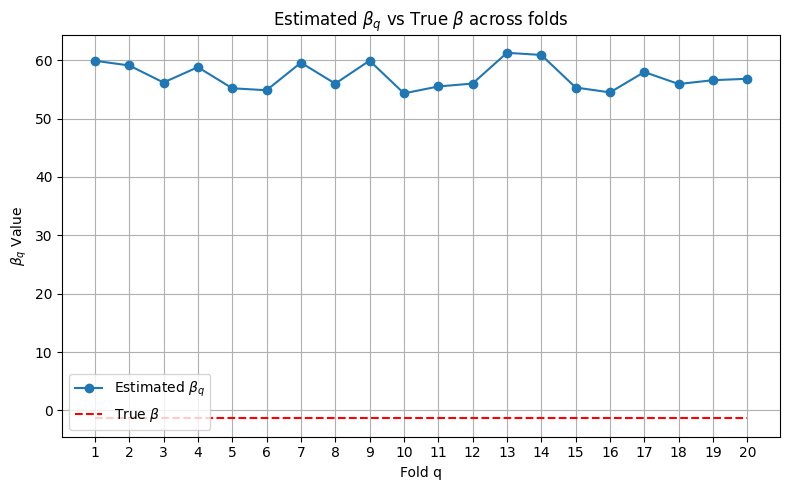

In [19]:
# Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(beta_q_list) + 1), beta_q_list, marker='o', label='Estimated $\\beta_q$')
plt.hlines(beta_0, 1, len(beta_q_list), colors='red', linestyles='dashed', label='True $\\beta$')
plt.xlabel('Fold q')
plt.ylabel('$\\beta_q$ Value')
plt.title('Estimated $\\beta_q$ vs True $\\beta$ across folds')
plt.xticks(range(1, len(beta_q_list) + 1))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()